<a href="https://colab.research.google.com/github/ryanou97/stock_predict_with_RNN/blob/main/stock_predict_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install twstock

import csv, os, time
import twstock

## twstock 台股資料
若無資料來源，可用台灣證券交易所的twstock套件抓取。不過沒辦法抓取整年，必須分每季下載，且每個IP有流量限制。


In [6]:
TSMC_stock = twstock.Stock('2330')

print("日期：",TSMC_stock.date[-1])
print("開盤價：",TSMC_stock.open[-1])
print("最高價：",TSMC_stock.high[-1])
print("最低價：",TSMC_stock.low[-1])
print("收盤價：",TSMC_stock.price[-1])

日期： 2023-11-10 00:00:00
開盤價： 555.0
最高價： 557.0
最低價： 554.0
收盤價： 557.0


## RNN 資料前處理


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

df = pd.read_csv('/content/2330.csv')

In [8]:
dfprice = pd.DataFrame(df['Close'])
dfprice

,Close
0,64.5
1,64.1
2,63.0
3,63.0
4,65.2
...,...
3836,550.0
3837,555.0
3838,556.0
3839,557.0


In [9]:
sequence_length = 10
data = []
for i in range(len(dfprice) - sequence_length):
    data.append(dfprice[i: i + sequence_length + 1])
print(data[0])

    Close
0    64.5
1    64.1
2    63.0
3    63.0
4    65.2
5    67.1
6    66.8
7    67.4
8    67.3
9    64.6
10   63.9


In [10]:
sequence_length = 10
scaler = MinMaxScaler()
dfprice = scaler.fit_transform(dfprice)
data = []
for i in range(len(dfprice) - sequence_length):
    data.append(dfprice[i: i + sequence_length + 1])

In [11]:
reshaped_data = np.array(data)
x = reshaped_data[:, :-1]
y = reshaped_data[:, -1]

In [12]:
split_boundary = int(reshaped_data.shape[0] * 0.8)
train_x = x[: split_boundary]
test_x = x[split_boundary:]
train_y = y[: split_boundary]
test_y = y[split_boundary:]
print('訓練資料數量：{}'.format(len(train_x)))
print('測試資料數量：{}'.format(len(test_x)))

訓練資料數量：3064
測試資料數量：767


## RNN 建立與訓練

In [13]:
model = Sequential()
model.add(LSTM(input_shape=(10,1), units=256, unroll=False))

In [14]:
model.add(Dense(units=1))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 264449 (1.01 MB)
Trainable params: 264449 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
model.compile(loss="mse", optimizer="adam",
              metrics=['accuracy'])
model.fit(train_x, train_y, batch_size=100,
          epochs=100, validation_split=0.2,
          verbose=2)
model.save('/content/stock_model.h5')

Epoch 1/100
25/25 - 2s - loss: 4.7159e-05 - accuracy: 4.0800e-04 - val_loss: 1.1089e-04 - val_accuracy: 0.0000e+00 - 2s/epoch - 93ms/step
Epoch 2/100
25/25 - 0s - loss: 1.3413e-05 - accuracy: 4.0800e-04 - val_loss: 1.0203e-04 - val_accuracy: 0.0000e+00 - 155ms/epoch - 6ms/step
Epoch 3/100
25/25 - 0s - loss: 1.2640e-05 - accuracy: 4.0800e-04 - val_loss: 1.1059e-04 - val_accuracy: 0.0000e+00 - 145ms/epoch - 6ms/step
Epoch 4/100
25/25 - 0s - loss: 1.3372e-05 - accuracy: 4.0800e-04 - val_loss: 1.4346e-04 - val_accuracy: 0.0000e+00 - 146ms/epoch - 6ms/step
Epoch 5/100
25/25 - 0s - loss: 1.4042e-05 - accuracy: 4.0800e-04 - val_loss: 9.8706e-05 - val_accuracy: 0.0000e+00 - 144ms/epoch - 6ms/step
Epoch 6/100
25/25 - 0s - loss: 1.3746e-05 - accuracy: 4.0800e-04 - val_loss: 1.0507e-04 - val_accuracy: 0.0000e+00 - 139ms/epoch - 6ms/step
Epoch 7/100
25/25 - 0s - loss: 1.6337e-05 - accuracy: 4.0800e-04 - val_loss: 1.0685e-04 - val_accuracy: 0.0000e+00 - 136ms/epoch - 5ms/step
Epoch 8/100
25/25 - 0s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 預測股票收盤價

24/24 [==============================] - 1s 2ms/step


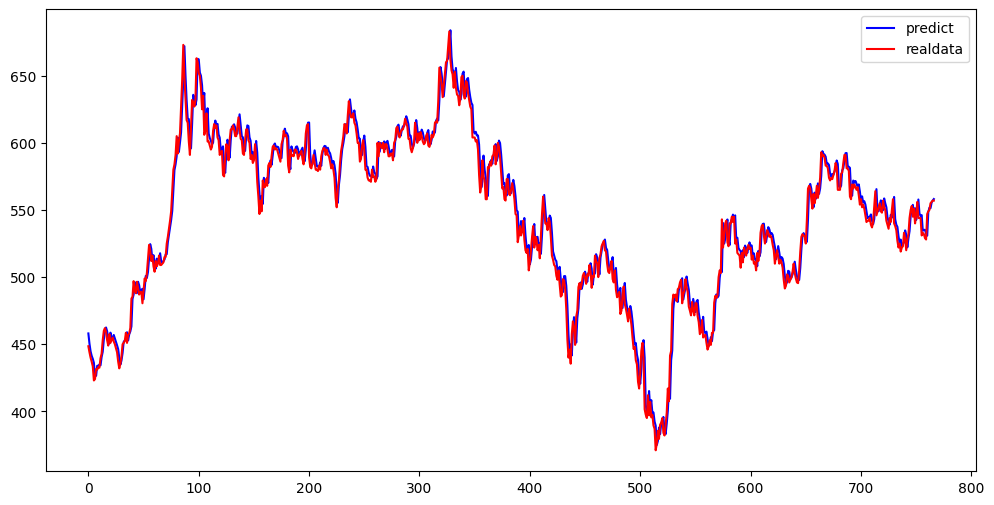

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model

df = pd.read_csv('/content/2330.csv', encoding='big5')
dfprice = pd.DataFrame(df['Close'])
sequence_length = 10
scaler = MinMaxScaler()
dfprice = scaler.fit_transform(dfprice)
data = []
for i in range(len(dfprice) - sequence_length):
    data.append(dfprice[i: i + sequence_length + 1])
reshaped_data = np.array(data)
x = reshaped_data[:, :-1]
y = reshaped_data[:, -1]
split_boundary = int(reshaped_data.shape[0] * 0.8)
train_x = x[: split_boundary]
test_x = x[split_boundary:]
train_y = y[: split_boundary]
test_y = y[split_boundary:]

model = load_model('stock_model.h5')
predict = model.predict(test_x)
predict = scaler.inverse_transform(predict)
test_y = scaler.inverse_transform(test_y)

plt.figure(figsize=(12,6))
plt.plot(predict, 'b-')
plt.plot(test_y, 'r-')
plt.legend(['predict', 'realdata'])
plt.show()